In [1]:
import sqlite3 as sq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec as gs
from matplotlib.ticker import MultipleLocator
# %matplotlib inline

In [2]:
data_base_name = 'Employee_Data.db'
table_one = "2009_v.1"
table_two = "2009_v.2"
table_three = "personal_data"

# creating a sex chart
with sq.connect(data_base_name) as con:
    # making a selection from the database to create a table 'Cтруктура работников цеха по половому признаку'
    gender_structure = pd.read_sql(f'''SELECT Sex, count(Sex) as Amount FROM
                            (
                            SELECT "Personnel number", Sex
                            from "{table_two}"
                            GROUP by "Personnel number"
                            )
                        GROUP by Sex''', con)

  Sex  Amount
0   Ж      45
1   М     155


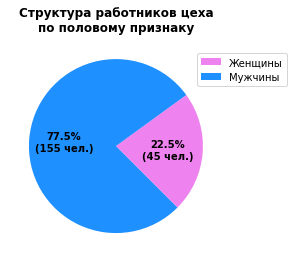

In [3]:
    # data on the number of men and women for the pie chart:
    values = gender_structure['Amount'].tolist()

    # data for pie chart legend:
    labels = ['Женщины' if s == 'Ж' else 'Мужчины' for s in gender_structure['Sex'].tolist()]

    # pie chart settings:
    my = plt.pie(values,
                 colors=('violet', 'dodgerblue'),
                 startangle=-45,
                 autopct=lambda x: f'{round(x, 1)}%\n({int(round(x * sum(values) / 100, 0))} чел.)',
                 textprops=dict(color="black", size=10, weight='bold')
                 )
    plt.title('Cтруктура работников цеха\nпо половому признаку',
              size=12,
              weight='bold',
              )

    plt.legend(labels, bbox_to_anchor=(0.85, 0.95))

    print(gender_structure)

    plt.show()

In [4]:
# creating an age chart
with sq.connect('Employee_Data.db') as con:
    # create a new DataFrame from DataBase:
    df = pd.read_sql(f'''select "Date of birth", Sex 
                        from "{table_two}"
                        group by "Personnel number"
                        ''', con)

    # change the data type in the column "Date of birth" from str to datetime:
    df['Date of birth'] = pd.to_datetime(df['Date of birth'])

    # create data for new df column "Age" (employee age in 2009 year):
    current_date = pd.to_datetime('2009-12-31')
    age = df['Date of birth'].apply(lambda d_of_b: int((current_date - d_of_b).days / 365))

    # add new column "Age" to DataFrame df:
    df['Age'] = age

    # delete column "Date of birth" from DataFrame df:
    df.drop('Date of birth', axis=1, inplace=True)

    # create a dictionary with data for the age chart:
    age_dict = {}

    for df_sex, df_age in df.values:
        age_dict.setdefault(df_sex, {'моложе 24': 0,
                                     'от 24 до 29': 0,
                                     'от 30 до 39': 0,
                                     'от 40 до 50': 0,
                                     'старше 50': 0})
        if df_age < 24:
            age_dict[df_sex]['моложе 24'] += 1
        if 23 < df_age < 30:
            age_dict[df_sex]['от 24 до 29'] += 1
        if 29 < df_age < 40:
            age_dict[df_sex]['от 30 до 39'] += 1
        if 39 < df_age < 51:
            age_dict[df_sex]['от 40 до 50'] += 1
        if 50 < df_age:
            age_dict[df_sex]['старше 50'] += 1

    # create a DataFrame with data for the age chart:
    age_df = pd.DataFrame(age_dict)

    # rename columns:
    axe_label = 'Возраст (лет)'
    m = 'Мужчины (чел.)'
    f = 'Женщины (чел.)'
    age_df.rename(columns={'М': f'{m}', 'Ж': f'{f}'}, inplace=True)

    # let's call the column with indexes:
    age_df.index.names = [f'{axe_label}']

               Мужчины (чел.)  Женщины (чел.)
Возраст (лет)                                
моложе 24                  16               7
от 24 до 29                18               8
от 30 до 39                42               8
от 40 до 50                42               9
старше 50                  37              13


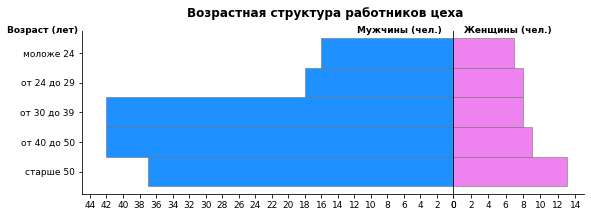

In [5]:
    # create the age chart:

    # create a 'figure' object to draw diagrams on it:
    fig = plt.figure(figsize=(9, 3))

    # create a grid on the 'figure' object to form cells for diagrams:
    gridsp = gs(ncols=50,  # number of columns
                nrows=1,  # number of rows
                figure=fig)

    # set the gap width between cells:
    plt.subplots_adjust(wspace=0)

    # set the size of the first diagram (i.e. in which cells it will be located) on the 'figure' object:
    ax1 = plt.subplot(gridsp[0, :37])

    # set the boundary values along the X axis:
    plt.xlim([0, age_df[f'{m}'].to_numpy().max() + 3])

    # set the scale step along the X axis:
    ax1.xaxis.set_major_locator(MultipleLocator(base=2))

    # turn the X-axis in the opposite direction:
    ax1.invert_xaxis()

    # turn the Y-axis in the opposite direction:
    ax1.invert_yaxis()

    # set the parameters of the first diagram (see the documentation for "pyplot.barh"):
    plt.barh(age_df.index.to_numpy(), age_df[f'{m}'],
             color='dodgerblue',
             height=1,
             edgecolor='dimgrey',
             linewidth=0.5,
             )
    # hide unnecessary chart axes (boundaries of the field in which the chart is built):
    ax1.spines['top'].set_visible(False)  # upper bound
    ax1.spines['right'].set_visible(False)  # right border

    # set the parameters (in this case, the font size) of the labels on the axes:
    plt.tick_params(axis='both', which='major', labelsize=9)

    # set the dimensions of the second diagram (i.e. in which cells it will be located) on the 'figure' object:
    ax2 = plt.subplot(gridsp[0, 37:], yticks=[])  # 'yticks' hides labels along the axis Y

    # set the boundary values along the X axis:
    plt.xlim([0, age_df[f'{f}'].to_numpy().max() + 2])

    # set the scale step along the X axis:
    ax2.xaxis.set_major_locator(MultipleLocator(base=2))

    # turn the Y-axis in the opposite direction:
    ax2.invert_yaxis()

    # set the parameters of the second diagram (see the documentation for "pyplot.barh"):
    plt.barh(age_df.index.to_numpy(), age_df[f'{f}'],
             color='violet',
             height=1,
             edgecolor='dimgrey',
             linewidth=0.5,
             )

    # hide unnecessary chart axes (boundaries of the field in which the chart is built):
    ax2.spines['top'].set_visible(False)  # upper bound
    ax2.spines['right'].set_visible(False)  # right border

    # set the parameters (in this case, the font size) of the labels on the axes:
    plt.tick_params(axis='x', which='major', labelsize=9)

    # add text to the object 'figure':
    fig.suptitle('Возрастная структура работников цеха',  # name of the finished chart
                 size=12,
                 weight='bold',
                 y=0.99
                 )
    plt.figtext(0.55, 0.87, f'{m}', weight='bold', size=9)  # labeling of the left diagram
    plt.figtext(0.715, 0.87, f'{f}', weight='bold', size=9)  # labeling of the right diagram
    plt.figtext(0.01, 0.87, f'{axe_label}', weight='bold', size=9)  # name of Y-axis

    print(age_df)
    plt.show()
